In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
# Load the dataset
df = pd.read_csv('train.csv')

In [25]:
# Step 2: Splitting the Dataset into features
X = df.drop('label', axis=1) # Inputs (Features) , axis = 1 means to drop only one coloumn 
y = df['label']  # Output => (Target)

In [26]:
# Step 3: Splitting the dataset into 80% Training and 20% Validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
# Create DataFrames with the normalized data
df_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
df_val_normalized = pd.DataFrame(X_val_normalized, columns=X_val.columns)

# Save the normalized DataFrames to CSV files
#df_train_normalized.to_csv('normalized_train_data.csv', index=False)
#df_val_normalized.to_csv('normalized_val_data.csv', index=False)


In [28]:
from torch.utils.data import Dataset, DataLoader
import torch


In [29]:
# Define a custom PyTorch dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [30]:
# Create datasets and data loaders for training and validation
train_dataset = CustomDataset(df_train_normalized, y_train)
val_dataset = CustomDataset(df_val_normalized, y_val)

batch_size = 64  # You can adjust this based on your needs

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [31]:

#creation of an archotecture
import torch.nn as nn

class DigitRecModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(DigitRecModel, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
       
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
   
        
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        # Define the forward pass
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x




In [32]:
input_size = 28 * 28  # Assuming images are 28x28 pixels
output_size = 10  # Number of classes (digits 0-9)
hidden_size1 = 256  
hidden_size2 = 128



simple_model = DigitRecModel(input_size,hidden_size1,hidden_size2, output_size)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume you have simple_model, train_loader, and val_loader defined

# losses and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Experiment with different learning rates and batch sizes
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]
batch_sizes = [32, 64, 128, 256, 512]
print("| Learning Rate | Batch Size | Epoch | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy |")
for lr in learning_rates:
    for batch_size in batch_sizes:
        # Define model, loss function, and optimizer with the current learning rate
        simple_model = DigitRecModel(input_size,hidden_size1,hidden_size2, output_size) # Replace YourModel with the actual model class
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(simple_model.parameters(), lr=lr)

        epochs = 3

        for epoch in range(epochs):
            simple_model.train()  # Set the model to training mode

            # Training
            correct_train = 0
            total_train = 0
            running_train_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = simple_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                running_train_loss += loss.item()

            train_accuracy = correct_train / total_train
            train_losses.append(running_train_loss / len(train_loader))
            train_accuracies.append(train_accuracy)

            # Validation
            simple_model.eval()  # Set the model to evaluation mode
            correct_val = 0
            total_val = 0
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = simple_model(inputs)
                    loss = criterion(outputs, labels)

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    running_val_loss += loss.item()

            val_accuracy = correct_val / total_val
            val_losses.append(running_val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

            # Print the loss and accuracy after each epoch for the current learning rate and batch size
           

            print(f' {lr}\t\t    {batch_size}'
                  f'\t       {epoch + 1}/{epochs} '
                  f'\t {train_losses[-1]:.4f} \t    {train_accuracy:.4f} '
                  f'\t    {val_losses[-1]:.4f} \t      {val_accuracy:.4f}')


| Learning Rate | Batch Size | Epoch | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy |
 0.001		    32	       1/3 	 2.2932 	    0.1287 	    2.2839 	      0.1758
 0.001		    32	       2/3 	 2.2728 	    0.2683 	    2.2619 	      0.3508
 0.001		    32	       3/3 	 2.2483 	    0.4201 	    2.2343 	      0.4693
 0.001		    64	       1/3 	 2.2945 	    0.1290 	    2.2842 	      0.1726
 0.001		    64	       2/3 	 2.2744 	    0.2205 	    2.2626 	      0.2633
 0.001		    64	       3/3 	 2.2508 	    0.3221 	    2.2363 	      0.3787
 0.001		    128	       1/3 	 2.2961 	    0.1663 	    2.2880 	      0.2188
 0.001		    128	       2/3 	 2.2806 	    0.2525 	    2.2715 	      0.2995
 0.001		    128	       3/3 	 2.2624 	    0.3287 	    2.2509 	      0.3693
 0.001		    256	       1/3 	 2.2980 	    0.1209 	    2.2900 	      0.1657
 0.001		    256	       2/3 	 2.2820 	    0.2195 	    2.2730 	      0.2713
 0.001		    256	       3/3 	 2.2634 	    0.3397 	    2.2524 	      0.4081
 0.

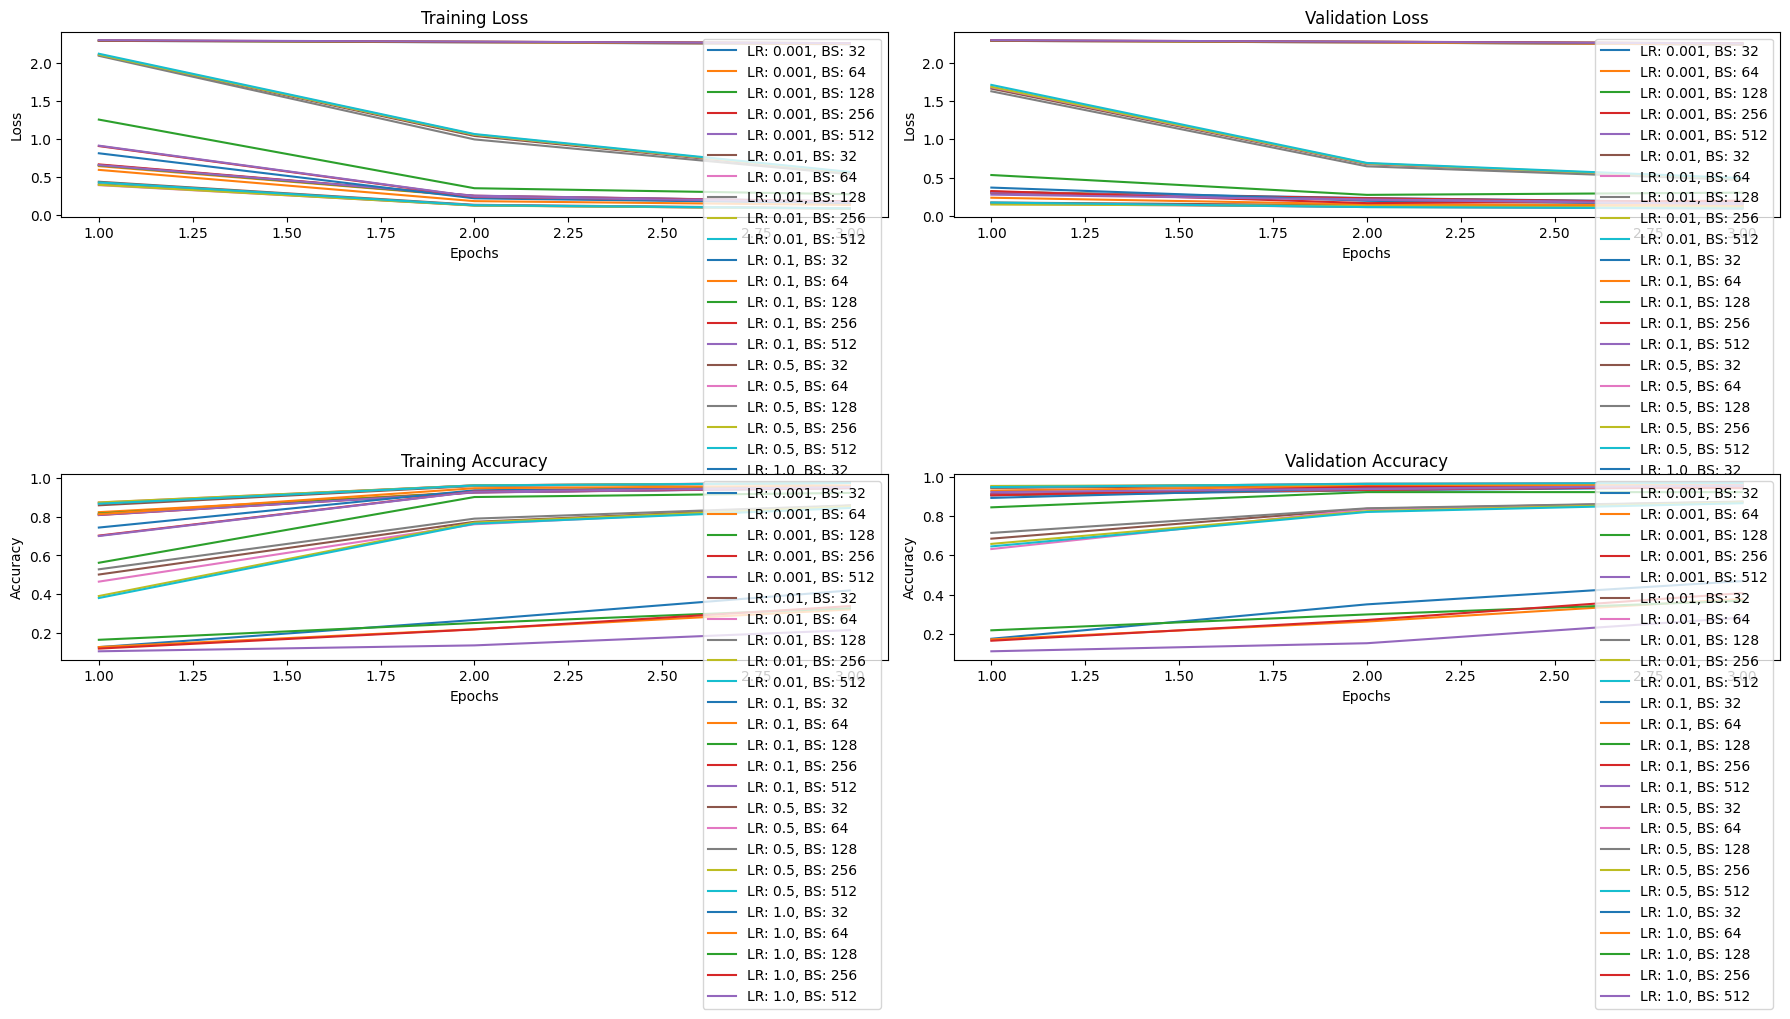

In [37]:
import matplotlib.pyplot as plt

# Assuming you have the lists or arrays defined
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]
batch_sizes = [32, 64, 128, 256, 512]

# Plotting Loss and Accuracy
plt.figure(figsize=(18, 9))

# Plotting Loss
plt.subplot(2, 2 , 1)  # train Loss plot

for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        label = f'LR: {lr}, BS: {batch_size}'
        start_idx = (i * len(batch_sizes) + j) * epochs
        end_idx = start_idx + epochs
        plt.plot(range(1, epochs + 1), train_losses[start_idx:end_idx], label=label)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()


plt.subplot(2, 2 , 2)  # val Loss plot
for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        label = f'LR: {lr}, BS: {batch_size}'
        start_idx = (i * len(batch_sizes) + j) * epochs
        end_idx = start_idx + epochs
        plt.plot(range(1, epochs + 1), val_losses[start_idx:end_idx], label=label)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()


# Plotting Accuracy
plt.subplot(2, 2, 3)  # tarin Accuracy plot

for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        label = f'LR: {lr}, BS: {batch_size}'
        start_idx = (i * len(batch_sizes) + j) * epochs
        end_idx = start_idx + epochs
        plt.plot(range(1, epochs + 1), train_accuracies[start_idx:end_idx], label=label)


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(2, 2, 4)  # val Accuracy plot

for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        label = f'LR: {lr}, BS: {batch_size}'
        start_idx = (i * len(batch_sizes) + j) * epochs
        end_idx = start_idx + epochs
        plt.plot(range(1, epochs + 1), val_accuracies[start_idx:end_idx], label=label)


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


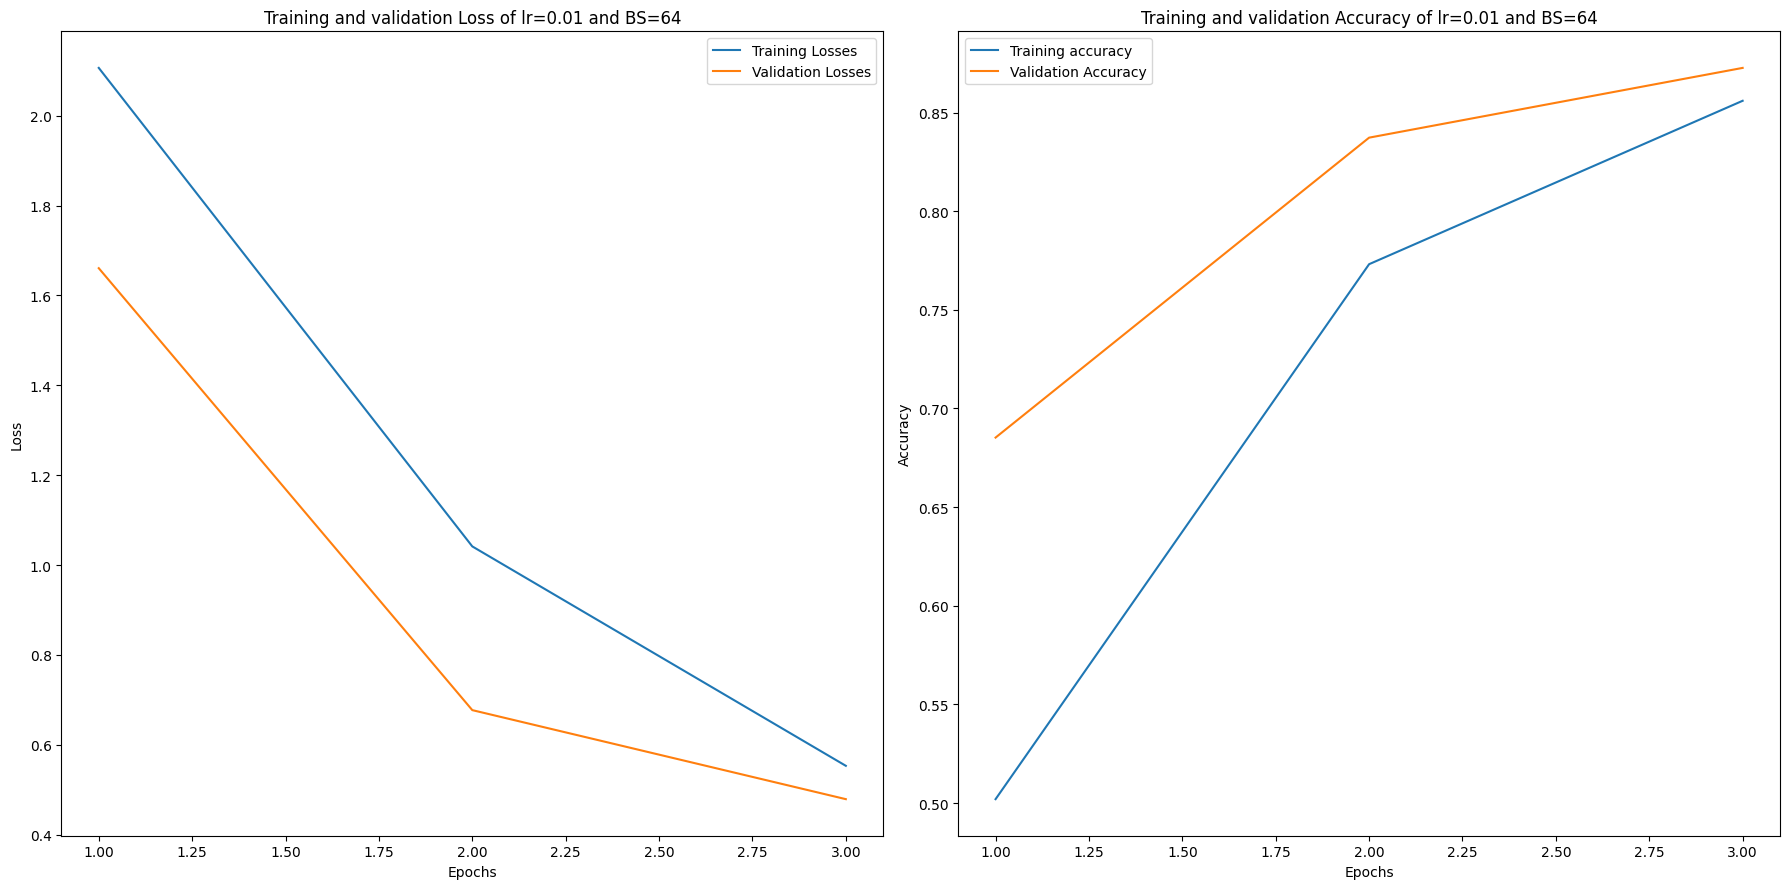

In [43]:
#3 the plots 
import matplotlib.pyplot as plt
# Plotting Loss and Accuracy
plt.figure(figsize=(18, 9))

# Plotting Loss
plt.subplot(1, 2, 1)  # Loss plot


label = f'LR:{0.01}, BS: {64}'
start_idx = (len(batch_sizes)) * epochs
end_idx = start_idx + epochs
plt.plot(range(1, epochs + 1), train_losses[start_idx:end_idx], label='Training Losses')
plt.plot(range(1, epochs + 1), val_losses[start_idx:end_idx], label='Validation Losses')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation Loss of lr=0.01 and BS=64')
plt.legend()

plt.subplot(1,2, 2)
label = f'LR: {0.01}, BS: {64}'
start_idx = ( len(batch_sizes)) * epochs
end_idx = start_idx + epochs
plt.plot(range(1, epochs + 1), train_accuracies[start_idx:end_idx], label='Training accuracy')
plt.plot(range(1, epochs + 1), val_accuracies[start_idx:end_idx], label='Validation Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy of lr=0.01 and BS=64')
plt.legend()

plt.tight_layout()
plt.show()

